In [1]:
import numpy as np
import pandas as pd
import math
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

In [2]:
answers={}
raw_data = pd.read_csv("/Users/rezaalemy/Downloads/Parking_Citations.csv", low_memory = False)

In [3]:
# fill missing  4530 Violation Date values by coalecing ViolDate, NoticeDate, and ImportDate

raw_data['CleanViolDate']=raw_data.apply(lambda row: row['ViolDate'] if type(row['ViolDate']) is str else \
                                         row['NoticeDate'] + ' 01:01:01 AM' if type(row['NoticeDate']) is str else row['ImportDate'], axis  = 1)
# and turn them into date objects
raw_data['ViolationDate'] =  pd.to_datetime(raw_data['CleanViolDate'], format = '%m/%d/%Y %I:%M:%S %p')

# and select citations before Jan 1, 2019
viol_data = raw_data[raw_data['ViolationDate'] < '2019-01-01']


In [4]:
# assert all rows have valid violation date
if viol_data['CleanViolDate'].isna().any():
    raise Exception('Assertion Error, expected no missing values in ViolationDate Column')

In [5]:
# Q1: mean fine for all citations:
answers['q1'] = viol_data.ViolFine.mean()

In [6]:
# Q2: 81st percentile of vehicles with open penalty fees:
answers['q2']=viol_data[viol_data['OpenPenalty'] > 0].quantile(0.81)['ViolFine']

In [7]:
# Q3: clean and find the police disctrict with highest mean violation fine
def clean_police_district(district):
    if type(district) is str: 
        district = district.upper()
        if district == 'NOTHEASTERN':
            district = 'NORTHEASTERN'
    return district
    
data = viol_data.copy(deep=False)
data['CleanedPoliceDistrict'] = data['PoliceDistrict'].apply(clean_police_district)

viol_by_district = data.groupby('CleanedPoliceDistrict').mean().sort_values('ViolFine', ascending=False)
answers['q3']=viol_by_district['ViolFine'][0]

In [8]:
#Q4: clean and find percentage for Japanese Vehicles in the top 10 for 2017
selected_violations = data.loc[data['ViolationDate'].between('2017-01-01', '2017-12-31', inclusive = True)]
make_citations = selected_violations[['Make', 'Citation']].groupby('Make').count()
#> make_citations.plot(figsize=(18,10))

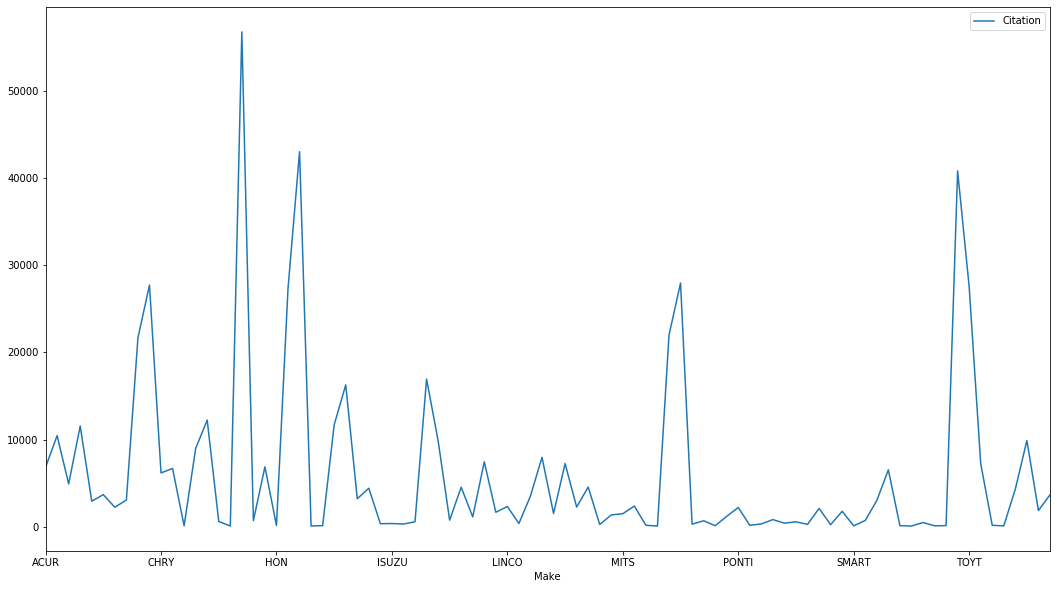

In [9]:
# from plot above, it looks like citations under 100 won't affect the result.
high_citations = make_citations[make_citations['Citation']>100]
# >high_citations.plot(figsize=(18,10))

In [10]:
# manually clean the makes, by copy-pasting and correcting values.
# >high_citations.index.values
# array(['ACUR', 'ACURA', 'AUDI', 'BMW', 'BUIC', 'BUICK', 'CADI', 'CADIL',
#       'CHEV', 'CHEVR', 'CHRY', 'CHRYS', 'DETAC', 'DODG', 'DODGE', 'FIAT',
#       'FOR', 'FORD', 'FREIG', 'GMC', 'HON', 'HOND', 'HONDA', 'HUMM',
#       'HUMME', 'HYUN', 'HYUND', 'INFI', 'INFIN', 'INTER', 'ISUZU',
#       'JAGU', 'JAGUA', 'JEEP', 'KIA', 'LAND', 'LEXS', 'LEXU', 'LEXUS',
#       'LINC', 'LINCO', 'LNDR', 'MAZD', 'MAZDA', 'MERC', 'MERCE', 'MERCU',
#       'MERZ', 'MINI', 'MINI-', 'MITS', 'MITSU', 'MNNI', 'NIS', 'NISS',
#       'NISSA', 'OLDS', 'OLDSM', 'PLYMO', 'PONT', 'PONTI', 'PORS',
#       'PORSC', 'RAM', 'RANGE', 'SAAB', 'SATU', 'SATUR', 'SCIO', 'SCION',
#       'SMART', 'STRN', 'SUBA', 'SUBAR', 'SUZI', 'SUZU', 'SUZUK', 'TOY',
#       'TOYO', 'TOYOT', 'TOYT', 'TRAIL', 'UNK', 'UNKN', 'VOLK', 'VOLKS',
#       'VOLV', 'VOLVO'], dtype=object)

In [11]:
cleaned_makes = ['ACURA', 'ACURA', 'AUDI', 'BMW', 'BUICK', 'BUICK', 'CADIL', 'CADIL',
       'CHEVY', 'CHEVY', 'CHEVY', 'CHEVY', 'DETAC', 'DODGE', 'DODGE', 'FIAT',
       'FORD', 'FORD', 'FREIG', 'GMC', 'HONDA', 'HONDA', 'HONDA', 'HUMM',
       'HUMM', 'HYUND', 'HYUND', 'INFIN', 'INFIN', 'INTER', 'ISUZU',
       'JAGUAR', 'JAGUAR', 'JEEP', 'KIA', 'LANDR', 'LEXUS', 'LEXUS', 'LEXUS',
       'LINCOLN', 'LINCOLN', 'LANDR', 'MAZDA', 'MAZDA', 'MERCEDES', 'MERCEDES', 'MERCU',
       'MERZ', 'MINI', 'MINI', 'MITSU', 'MITSU', 'MINI', 'NISSAN', 'NISSAN',
       'NISSAN', 'OLDS', 'OLDS', 'PLYMO', 'PONT', 'PONT', 'PORSC',
       'PORSC', 'RAM', 'RANGE', 'SAAB', 'SATURN', 'SATURN', 'SCION', 'SCION',
       'SMART', 'SATURN', 'SUBARU', 'SUBARU', 'SUZUKI', 'SUZUKI', 'SUZUKI', 'TOYOTA',
       'TOYOTA', 'TOYOTA', 'TOYOTA', 'TRAIL', 'UNKNOWN', 'UNKNOWN', 'VOLKS', 'VOLKS',
       'VOLVO', 'VOLVO']

In [12]:
# add the cleaned list and redo the grouping to find the top ten
series = pd.Series(cleaned_makes)
cleaned_high_citations = high_citations.copy(deep=False)
cleaned_high_citations['cleaned_makes'] = cleaned_makes
top_ten = cleaned_high_citations.groupby('cleaned_makes').sum().sort_values('Citation', ascending=False).iloc[:10]

In [13]:
# manually get the top ten makes and decide whether they are Japanese made
# top_ten.index.values
# array(['HONDA', 'TOYOTA', 'CHEVY', 'FORD', 'NISSAN', 'HYUND', 'DODGE',
#       'ACURA', 'JEEP', 'VOLKS'], dtype=object)

In [14]:
# add the classifier and solve the problem.
is_japanese = ['Y', 'Y', 'N', 'N', 'Y', 'Y', 'N',
       'Y', 'N', 'N']
top_ten_maker = top_ten.copy(deep=False)
top_ten_maker['Japanese'] = is_japanese
japanese_citations = top_ten_maker.groupby('Japanese').sum().loc['Y']['Citation']
# question is asking for proportion of ALL citations, not just 2017 citations.
all_citations = data.shape[0]
answers['q4'] = japanese_citations / all_citations

In [15]:
#Q5: Slope of linear regression for citation number over date
yearly_violations = raw_data[['ViolationDate','Citation']].groupby(pd.Grouper(key='ViolationDate', freq="Y"))\
                .count()['2004-01-01': '2015-01-01']

In [16]:
# >yearly_violations.plot(figsize=(18,5))

In [17]:
# simple scikit-learn linear regression

regressor = LinearRegression()
X = np.array([ i.year for i in yearly_violations.index]).reshape(-1,1)
Y = yearly_violations.iloc[:,0].values.reshape(-1,1)
regressor.fit(X,Y)
Y_pred = regressor.predict(X)

In [18]:
# >plt.scatter(X,Y)
# >plt.plot(X, Y_pred, color='green')
# >plt.show()

In [19]:
# intercept
b = regressor.intercept_[0]
# slope
answers['q5'] = regressor.coef_[0][0]


In [20]:
# Q6 : ration of auto theft to citation

raw_crime = pd.read_csv("/Users/rezaalemy/Downloads/BPD_Part_1_Victim_Based_Crime_Data.csv")

In [21]:
# >raw_crime.District.unique()
# array(['CENTRAL', 'EASTERN', 'NORTHEAST', 'NORTHERN', 'NORTHWEST',
#       'SOUTHEAST', 'SOUTHERN', 'SOUTHWEST', 'WESTERN'], dtype=object)

In [22]:
# select auto theft for known districts
district_crime = raw_crime[raw_crime['District']!= 'UNKNOWN']
district_auto_theft = district_crime[district_crime['Description'] == 'AUTO THEFT']

In [23]:
# select 2015 auth theft data
crime_data = district_auto_theft.copy(deep=False)
crime_data['CleanedCrimeDate'] = pd.to_datetime(district_auto_theft['CrimeDate'], format = '%m/%d/%Y')

In [24]:
crime_data = crime_data[crime_data['CleanedCrimeDate'].between('2015-01-01', '2015-12-31', inclusive = True)]

In [25]:
crime_2015 = crime_data[['District', 'CrimeDate']].groupby('District').count().rename(columns = {'CrimeDate': 'CrimeCount'})

In [26]:
# select 2015 violation data
violations_2015 = data.loc[data['ViolationDate'].between('2015-01-01', '2015-12-31', inclusive = True)]

In [27]:
district_violations_2015  = violations_2015[['CleanedPoliceDistrict','Citation']].groupby('CleanedPoliceDistrict').count()

In [28]:
# create join index 
# >district_violations_2015.index.values\
# array(['CENTRAL', 'EASTERN', 'NORTHEASTERN', 'NORTHERN', 'NORTHWESTERN',
#       'SOUTHEASTERN', 'SOUTHERN', 'SOUTHWESTERN', 'WESTERN'],
#      dtype=object)

In [29]:
# >crime_2015.index.values
# array(['CENTRAL', 'EASTERN', 'NORTHEAST', 'NORTHERN', 'NORTHWEST',
#       'SOUTHEAST', 'SOUTHERN', 'SOUTHWEST', 'WESTERN'], dtype=object)

In [30]:
districts = ['CENTRAL', 'EASTERN', 'NORTHEASTERN', 'NORTHERN', 'NORTHWESTERN',
       'SOUTHEASTERN', 'SOUTHERN', 'SOUTHWESTERN', 'WESTERN']

In [31]:
district_crime_2015 = crime_2015.copy(deep=False)
district_crime_2015['CleanedPoliceDistrict'] = districts

In [32]:
district_crime_2015 = district_crime_2015.set_index('CleanedPoliceDistrict')

In [33]:
district_crime_violations = district_crime_2015.join(district_violations_2015)


In [34]:
district_crime_violations['ratio'] = district_crime_violations['CrimeCount']/district_crime_violations['Citation']

In [35]:
answers['q6'] = district_crime_violations.sort_values('ratio', ascending=False).iloc[0][2]

In [36]:
answers

{'q1': 49.15971838758262,
 'q2': 52.0,
 'q3': 60.9117357810195,
 'q4': 0.08241135025983772,
 'q5': 11344.263636363641,
 'q6': 0.328505214368482}